In [62]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib
from pprint import pprint
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

im_list = ['流動資產合計', 
           '非流動資產合計', 
           '流動負債合計', 
           '非流動負債合計', 
           '資產總計', 
           '負債總計', 
           '保留盈餘合計', 
           '權益總計', 
           '權益總額',
           '負債與群益總計', 
           '營業收入合計', 
           '營業毛利（毛損）', 
           '營業利益（損失）',
           '本期淨利（淨損）',
           '營運產生之現金流入（流出）',
           '投資活動之淨現金流入（流出）',
           '籌資活動之淨現金流入（流出）']

# TSMC
# url = 'https://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=2330&SYEAR=2018&SSEASON=2&REPORT_ID=C'
# DATONG
# url = 'https://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=2371&SYEAR=2018&SSEASON=2&REPORT_ID=C'

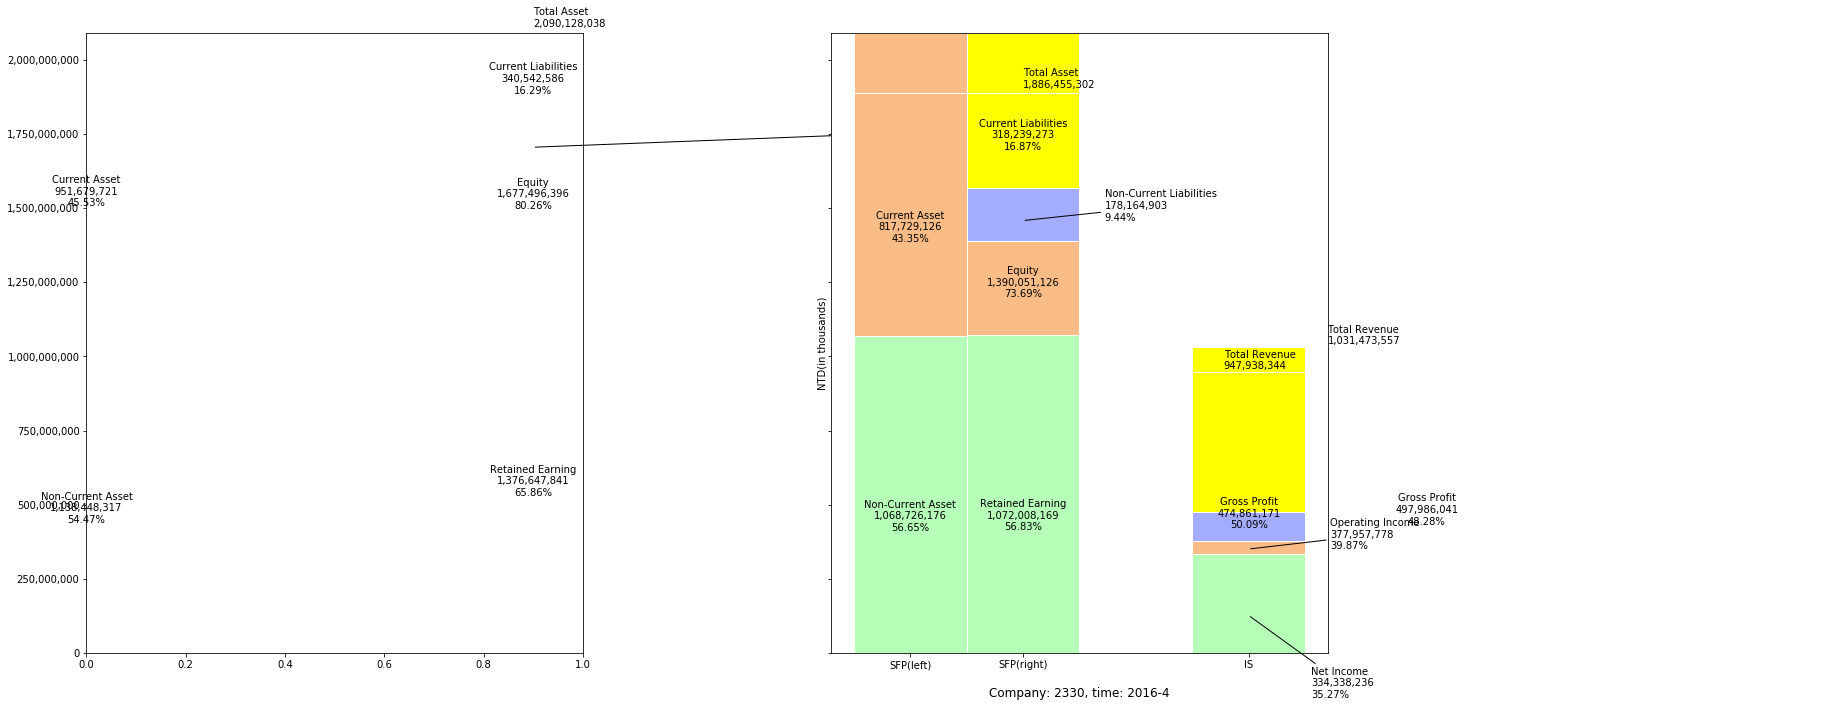

In [2]:
# Creates two subplots and unpacks the output array immediately

lst = [ (2330, 2018, 4), (2330, 2016, 4) ]
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,10))

for i in range( len(lst) ):

    # get data from web

    co_id = str(lst[i][0])
    year = str(lst[i][1])
    season = str(lst[i][2])

    url = 'https://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=' + co_id + '&SYEAR=' + year + '&SSEASON=' + season + '&REPORT_ID=C'
    response = requests.get( url )
    response.encoding = 'big5'
    soup = BeautifulSoup( response.text, 'lxml')

    # retrieve key data

    acct_dict = {}

    for tr in soup.find_all('tr'):
    
        try:
            if tr.contents[0].string.strip() in im_list and len( tr.contents ) < 10:  
                acct_dict[ ( tr.contents[0].string.strip() ) ] = int( ''.join( tr.contents[1].string.strip().split(',') ) )
            
        except (IndexError, AttributeError) as error:
            pass


    # clean data for drawing

    a = max(acct_dict['資產總計'], acct_dict['營業收入合計']) # this is the baseline for all the points

    r = [0, 0.9, 2.7] # position of drawing 3 bars, we want one and two to be close

    # generate each 'floor' of data, since we are stacking the bars
    raw_data = { 'first_floor': [acct_dict['非流動資產合計'],
                                 acct_dict['保留盈餘合計'], 
                                 acct_dict['本期淨利（淨損）']],
                'second_floor': [acct_dict['流動資產合計'],
                                 acct_dict['權益總計'] - acct_dict['保留盈餘合計'],
                                 acct_dict['營業利益（損失）'] - acct_dict['本期淨利（淨損）']],
                'third_floor': [0,
                                acct_dict['非流動負債合計'],
                                acct_dict['營業毛利（毛損）'] - acct_dict['營業利益（損失）']],
                'fourth_floor': [0,
                                 acct_dict['流動負債合計'],
                                 acct_dict['營業收入合計'] - acct_dict['營業毛利（毛損）']] }
    df = pd.DataFrame(raw_data)

    # plotting

    # fig, axs[i] = plt.subplots(figsize=(12, 9))
    # plot
    barWidth = 0.9
    names = ('SFP(left)', 'SFP(right)', 'IS')

    # create bars, remember we are stacking it
    # Create green Bars
    first = plt.bar(r, df['first_floor'], color='#b5ffb9', edgecolor='white', width=barWidth)
    # Create orange Bars
    second = plt.bar(r, df['second_floor'], bottom=df['first_floor'], color='#f9bc86', edgecolor='white', width=barWidth)
    # Create blue Bars
    third = plt.bar(r, df['third_floor'], bottom=[i + j for i, j in zip(df['first_floor'], df['second_floor'])], 
                    color='#a3acff', edgecolor='white', width=barWidth)
    # Create yellow Bars
    fourth = plt.bar(r, df['fourth_floor'], 
                     bottom=[i + j + k for i, j, k in zip(df['first_floor'], df['second_floor'], df['third_floor'])],
                     color='#ffff00', edgecolor='white', width=barWidth)

    # generate the tags
    first_label = ['Non-Current Asset\n' + '{:20,}'.format(acct_dict['非流動資產合計']).strip() + '\n' 
                   + str( round( ( acct_dict['非流動資產合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Retained Earning\n' + '{:20,}'.format(acct_dict['保留盈餘合計']).strip() + '\n' 
                   + str( round( ( acct_dict['保留盈餘合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Net Income\n' + '{:20,}'.format(acct_dict['本期淨利（淨損）']).strip() + '\n' 
                   + str( round( (acct_dict['本期淨利（淨損）'] / acct_dict['營業收入合計']) * 100, 2 ) ) + '%']

    second_label = ['Current Asset\n' + '{:20,}'.format(acct_dict['流動資產合計']).strip() + '\n' 
                   + str( round( ( acct_dict['流動資產合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Equity\n' + '{:20,}'.format(acct_dict['權益總計']).strip() + '\n' 
                   + str( round( ( acct_dict['權益總計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Operating Income\n' + '{:20,}'.format(acct_dict['營業利益（損失）']).strip() + '\n' 
                   + str( round( (acct_dict['營業利益（損失）']  / acct_dict['營業收入合計']) * 100, 2 ) )
                   + '%']

    third_label = ["",
                   'Non-Current Liabilities\n' + '{:20,}'.format(acct_dict['非流動負債合計']).strip() + '\n' 
                   + str( round( ( acct_dict['非流動負債合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Gross Profit\n' + '{:20,}'.format(acct_dict['營業毛利（毛損）']).strip() + '\n' 
                   + str( round( ( acct_dict['營業毛利（毛損）'] / acct_dict['營業收入合計']) * 100, 2 ) ) 
                   + '%']

    fourth_label = ["",
                   'Current Liabilities\n' + '{:20,}'.format(acct_dict['流動負債合計']).strip() + '\n' 
                   + str( round( ( acct_dict['流動負債合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   "" ]

    # post tags on the plot
    for idx, rect in enumerate(first):
        height = rect.get_height()
        if float( first_label[idx].split('\n')[2][:-1] ) < 10 or idx == 2 :
            axs[i].annotate( s=first_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height), 
                        xytext=(rect.get_x()+0.5 + rect.get_width()/2., -0.08 * a), arrowprops=dict(arrowstyle='-') )
        else:
            axs[i].text(rect.get_x() + rect.get_width()/2., 0.38*height , first_label[idx], 
                    ha='center', va='bottom', rotation=0)

    for idx, rect in enumerate(second):
        height = rect.get_height()
        height1 = first[idx].get_height()
        if float( second_label[idx].split('\n')[2][:-1] ) < 10 or idx == 2 :
            axs[i].annotate( s=second_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1), 
                        xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1),
                        arrowprops=dict(arrowstyle='-') )
        else:
            axs[i].text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 , second_label[idx], 
                    ha='center', va='bottom', rotation=0)

    for idx, rect in enumerate(third):
        height = rect.get_height()
        height1 = first[idx].get_height()
        height2 = second[idx].get_height()
        try:
            if float( third_label[idx].split('\n')[2][:-1] ) < 10 :
                axs[i].annotate( s=third_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2), 
                            xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1 + height2),
                            arrowprops=dict(arrowstyle='-') )
            else:
                axs[i].text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 , third_label[idx], 
                        ha='center', va='bottom', rotation=0)
        except IndexError:
            pass
    
    for idx, rect in enumerate(fourth):
        height = rect.get_height()
        height1 = first[idx].get_height()
        height2 = second[idx].get_height()
        height3 = third[idx].get_height()
        try:
            if float( fourth_label[idx].split('\n')[2][:-1] ) < 10 :
                axs[i].annotate( s=fourth_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 + height3), 
                            xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1 + height2 + height3),
                            arrowprops=dict(arrowstyle='-') )
            else:
                axs[i].text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 + height3 , fourth_label[idx], 
                        ha='center', va='bottom', rotation=0)
        except IndexError:
            pass

    axs[i].text(0.9, 1.01 * acct_dict['資產總計'], 'Total Asset\n' + '{:20,}'.format(acct_dict['資產總計']).strip() )
    axs[i].text(2.5, 1.01 * acct_dict['營業收入合計'], 'Total Revenue\n' + '{:20,}'.format(acct_dict['營業收入合計']).strip() )
# Custom x axs[i]is
    plt.xticks(r, names)
# plt.xlabel("Financial Statement")
# a = maxs[i](acct_dict['資產總計'], acct_dict['營業收入合計'])
# plt.yticks(np.arange(0, 1.03*a, 0.1*a), ['{:20,}'.format(n).strip() for n in np.arange(0, 1.03*a, 0.1*a )])
    plt.ylabel("NTD(in thousands)")
    plt.title('Company: ' + co_id + ', time: ' + year + '-' + season, y=-0.08)
# Show graphic
    fig.tight_layout()
    axs[i].get_yaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# axs[i].ticklabel_format(style='plain')
#     plt.show()
#     fig.savefig('whatever.png', facecolor='white' )
# 可能小於 10 % 就要拉出來
# 拉出來其實可以定位好的，利用本身的高跟寬
# 損益表到底要用累積還是？

#     print('--------------------- Cash Flow ---------------------')
#     print('營業現金流：'+'{:15,}'.format( acct_dict['營運產生之現金流入（流出）'] ) )
#     print('投資現金流：'+'{:15,}'.format( acct_dict['投資活動之淨現金流入（流出）'] ) )
#     print('籌資現金流：'+'{:15,}'.format( acct_dict['籌資活動之淨現金流入（流出）'] ) )

In [57]:
def Visualize_Financial_Statement( co_id, year, season ):

    co_id = str(co_id)
    year = str(year)
    season = str(season)


##################################### don't move code below ##############################################################
    url = 'https://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=' + co_id + '&SYEAR=' + year + '&SSEASON=' + season + '&REPORT_ID=C'
    response = requests.get( url )
    response.encoding = 'big5'
    soup = BeautifulSoup( response.text, 'lxml')

# retrieve key data

    acct_dict = {}

    for tr in soup.find_all('tr'):
    
        try:
            if tr.contents[0].string.strip() in im_list and len( tr.contents ) < 10:  
                acct_dict[ ( tr.contents[0].string.strip() ) ] = int( ''.join( tr.contents[1].string.strip().split(',') ) )
            
        except (IndexError, AttributeError) as error:
            pass
    
    print('------------------------- Data -------------------------')
    pprint( acct_dict )


    print('--------------------- Visulization ---------------------')
# clean data for drawing

    a = max(acct_dict['資產總計'], acct_dict['營業收入合計']) # this is the baseline for all the points

    r = [0, 0.9, 2.7]

    raw_data = { 'first_floor': [acct_dict['非流動資產合計'],
                                 acct_dict['保留盈餘合計'], 
                                 acct_dict['本期淨利（淨損）']],
                'second_floor': [acct_dict['流動資產合計'],
                                 acct_dict['權益總計'] - acct_dict['保留盈餘合計'],
                                 acct_dict['營業利益（損失）'] - acct_dict['本期淨利（淨損）']],
                'third_floor': [0,
                                acct_dict['非流動負債合計'],
                                acct_dict['營業毛利（毛損）'] - acct_dict['營業利益（損失）']],
                'fourth_floor': [0,
                                 acct_dict['流動負債合計'],
                                 acct_dict['營業收入合計'] - acct_dict['營業毛利（毛損）']] }
    df = pd.DataFrame(raw_data)

# plotting

    fig, ax = plt.subplots(figsize=(12, 9))
# plot
    barWidth = 0.9
    names = ('SFP(left)', 'SFP(right)', 'IS')
# Create green Bars
    first = plt.bar(r, df['first_floor'], color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
    second = plt.bar(r, df['second_floor'], bottom=df['first_floor'], color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
    third = plt.bar(r, df['third_floor'], bottom=[i + j for i, j in zip(df['first_floor'], df['second_floor'])], 
                    color='#a3acff', edgecolor='white', width=barWidth)
# Create yellow Bars
    fourth = plt.bar(r, df['fourth_floor'], 
                     bottom=[i + j + k for i, j, k in zip(df['first_floor'], df['second_floor'], df['third_floor'])],
                     color='#ffff00', edgecolor='white', width=barWidth)

        
    first_label = ['Non-Current Asset\n' + '{:20,}'.format(acct_dict['非流動資產合計']).strip() + '\n' 
                   + str( round( ( acct_dict['非流動資產合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Retained Earning\n' + '{:20,}'.format(acct_dict['保留盈餘合計']).strip() + '\n' 
                   + str( round( ( acct_dict['保留盈餘合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Net Income\n' + '{:20,}'.format(acct_dict['本期淨利（淨損）']).strip() + '\n' 
                   + str( round( (acct_dict['本期淨利（淨損）'] / acct_dict['營業收入合計']) * 100, 2 ) ) + '%']

    second_label = ['Current Asset\n' + '{:20,}'.format(acct_dict['流動資產合計']).strip() + '\n' 
                   + str( round( ( acct_dict['流動資產合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Equity\n' + '{:20,}'.format(acct_dict['權益總計']).strip() + '\n' 
                   + str( round( ( acct_dict['權益總計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Operating Income\n' + '{:20,}'.format(acct_dict['營業利益（損失）']).strip() + '\n' 
                   + str( round( (acct_dict['營業利益（損失）']  / acct_dict['營業收入合計']) * 100, 2 ) )
                   + '%']

    third_label = ["",
                   'Non-Current Liabilities\n' + '{:20,}'.format(acct_dict['非流動負債合計']).strip() + '\n' 
                   + str( round( ( acct_dict['非流動負債合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   'Gross Profit\n' + '{:20,}'.format(acct_dict['營業毛利（毛損）']).strip() + '\n' 
                   + str( round( ( acct_dict['營業毛利（毛損）'] / acct_dict['營業收入合計']) * 100, 2 ) ) 
                   + '%']

    fourth_label = ["",
                   'Current Liabilities\n' + '{:20,}'.format(acct_dict['流動負債合計']).strip() + '\n' 
                   + str( round( ( acct_dict['流動負債合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
                   "" ]


    for idx, rect in enumerate(first):
        height = rect.get_height()
        if float( first_label[idx].split('\n')[2][:-1] ) < 10 or idx == 2 :
            ax.annotate( s=first_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height), 
                        xytext=(rect.get_x()+0.5 + rect.get_width()/2., -0.08 * a), arrowprops=dict(arrowstyle='-') )
        else:
            ax.text(rect.get_x() + rect.get_width()/2., 0.38*height , first_label[idx], 
                    ha='center', va='bottom', rotation=0)

    for idx, rect in enumerate(second):
        height = rect.get_height()
        height1 = first[idx].get_height()
        if float( second_label[idx].split('\n')[2][:-1] ) < 10 or idx == 2 :
            ax.annotate( s=second_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1), 
                        xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1),
                        arrowprops=dict(arrowstyle='-') )
        else:
            ax.text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 , second_label[idx], 
                    ha='center', va='bottom', rotation=0)

    for idx, rect in enumerate(third):
        height = rect.get_height()
        height1 = first[idx].get_height()
        height2 = second[idx].get_height()
        try:
            if float( third_label[idx].split('\n')[2][:-1] ) < 10 :
                ax.annotate( s=third_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2), 
                            xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1 + height2),
                            arrowprops=dict(arrowstyle='-') )
            else:
                ax.text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 , third_label[idx], 
                        ha='center', va='bottom', rotation=0)
        except IndexError:
            pass
    
    for idx, rect in enumerate(fourth):
        height = rect.get_height()
        height1 = first[idx].get_height()
        height2 = second[idx].get_height()
        height3 = third[idx].get_height()
        try:
            if float( fourth_label[idx].split('\n')[2][:-1] ) < 10 :
                ax.annotate( s=fourth_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 + height3), 
                            xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1 + height2 + height3),
                            arrowprops=dict(arrowstyle='-') )
            else:
                ax.text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 + height3 , fourth_label[idx], 
                        ha='center', va='bottom', rotation=0)
        except IndexError:
            pass

    ax.text(0.9, 1.01 * acct_dict['資產總計'], 'Total Asset\n' + '{:20,}'.format(acct_dict['資產總計']).strip() )
    ax.text(2.5, 1.01 * acct_dict['營業收入合計'], 'Total Revenue\n' + '{:20,}'.format(acct_dict['營業收入合計']).strip() )
# Custom x axis
    plt.xticks(r, names)
# plt.xlabel("Financial Statement")
# a = max(acct_dict['資產總計'], acct_dict['營業收入合計'])
# plt.yticks(np.arange(0, 1.03*a, 0.1*a), ['{:20,}'.format(n).strip() for n in np.arange(0, 1.03*a, 0.1*a )])
    plt.ylabel("NTD(in thousands)")
    plt.title('Company: ' + co_id + ', time: ' + year + '-' + season, y=-0.08)
# Show graphic
    fig.tight_layout()
    ax.get_yaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# ax.ticklabel_format(style='plain')
    plt.show()
#     fig.savefig('whatever.png', facecolor='white' )
# 可能小於 10 % 就要拉出來
# 拉出來其實可以定位好的，利用本身的高跟寬
# 損益表到底要用累積還是？

    print('--------------------- Cash Flow ---------------------')
    print('營業現金流：'+'{:15,}'.format( acct_dict['營運產生之現金流入（流出）'] ) )
    print('投資現金流：'+'{:15,}'.format( acct_dict['投資活動之淨現金流入（流出）'] ) )
    print('籌資現金流：'+'{:15,}'.format( acct_dict['籌資活動之淨現金流入（流出）'] ) )

------------------------- Data -------------------------
{'保留盈餘合計': 1376647841,
 '投資活動之淨現金流入（流出）': -314268908,
 '本期淨利（淨損）': 351184406,
 '權益總計': 1677496396,
 '流動負債合計': 340542586,
 '流動資產合計': 951679721,
 '營業利益（損失）': 383623524,
 '營業收入合計': 1031473557,
 '營業毛利（毛損）': 497986041,
 '營運產生之現金流入（流出）': 619336831,
 '籌資活動之淨現金流入（流出）': -245124791,
 '負債總計': 412631642,
 '資產總計': 2090128038,
 '非流動負債合計': 72089056,
 '非流動資產合計': 1138448317}
--------------------- Visulization ---------------------


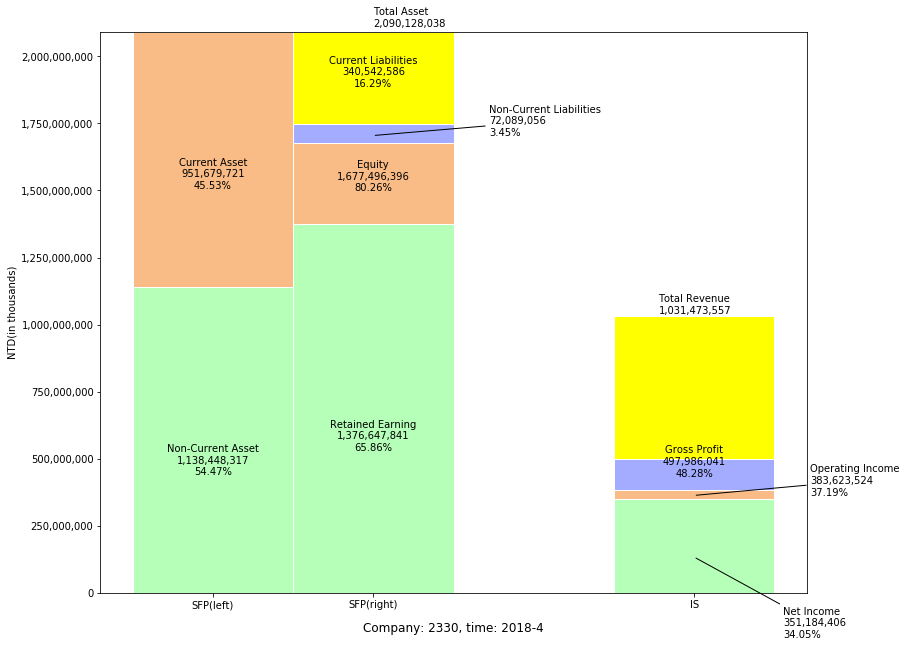

--------------------- Cash Flow ---------------------
營業現金流：    619,336,831
投資現金流：   -314,268,908
籌資現金流：   -245,124,791


In [59]:
Visualize_Financial_Statement(2330, 2018, 4)

------------------------- Data -------------------------
{'保留盈餘合計': 1376647841,
 '投資活動之淨現金流入（流出）': -314268908,
 '本期淨利（淨損）': 351184406,
 '權益總計': 1677496396,
 '流動負債合計': 340542586,
 '流動資產合計': 951679721,
 '營業利益（損失）': 383623524,
 '營業收入合計': 1031473557,
 '營業毛利（毛損）': 497986041,
 '營運產生之現金流入（流出）': 619336831,
 '籌資活動之淨現金流入（流出）': -245124791,
 '負債總計': 412631642,
 '資產總計': 2090128038,
 '非流動負債合計': 72089056,
 '非流動資產合計': 1138448317}
--------------------- Visulization ---------------------


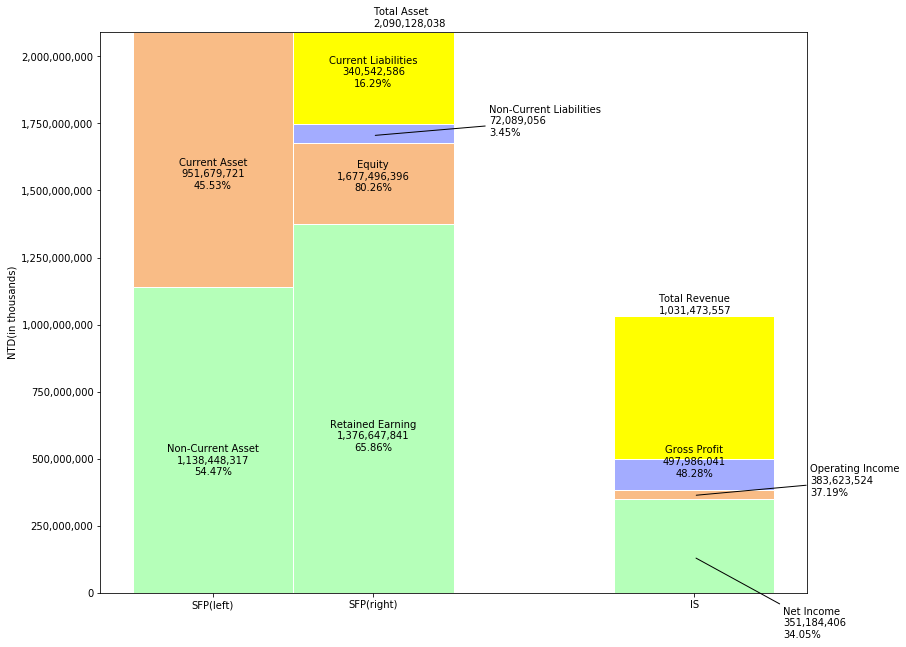

--------------------- Cash Flow ---------------------
營業現金流：    619,336,831
投資現金流：   -314,268,908
籌資現金流：   -245,124,791


In [5]:
co_id = '2330'
year = '2018'
season = '4'


##################################### don't move code below ##############################################################
url = 'https://mops.twse.com.tw/server-java/t164sb01?step=1&CO_ID=' + co_id + '&SYEAR=' + year + '&SSEASON=' + season + '&REPORT_ID=C'
response = requests.get( url )
response.encoding = 'big5'
soup = BeautifulSoup( response.text, 'lxml')

# retrieve key data

acct_dict = {}

for tr in soup.find_all('tr'):
    
    try:
        if tr.contents[0].string.strip() in im_list and len( tr.contents ) < 10:  
            acct_dict[ ( tr.contents[0].string.strip() ) ] = int( ''.join( tr.contents[1].string.strip().split(',') ) )
            
    except (IndexError, AttributeError) as error:
        pass
    
print('------------------------- Data -------------------------')
pprint( acct_dict )


print('--------------------- Visulization ---------------------')
# clean data for drawing

a = max(acct_dict['資產總計'], acct_dict['營業收入合計'])

r = [0, 0.9, 2.7]

raw_data = { 'first_floor': [acct_dict['非流動資產合計'],
                             acct_dict['保留盈餘合計'], 
                             acct_dict['本期淨利（淨損）']],
            'second_floor': [acct_dict['流動資產合計'],
                             acct_dict['權益總計'] - acct_dict['保留盈餘合計'],
                             acct_dict['營業利益（損失）'] - acct_dict['本期淨利（淨損）']],
            'third_floor': [0,
                            acct_dict['非流動負債合計'],
                            acct_dict['營業毛利（毛損）'] - acct_dict['營業利益（損失）']],
            'fourth_floor': [0,
                             acct_dict['流動負債合計'],
                             acct_dict['營業收入合計'] - acct_dict['營業毛利（毛損）']] }
df = pd.DataFrame(raw_data)

# plotting

fig, ax = plt.subplots(figsize=(12, 9))
# plot
barWidth = 0.9
names = ('SFP(left)', 'SFP(right)', 'IS')
# Create green Bars
first = plt.bar(r, df['first_floor'], color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
second = plt.bar(r, df['second_floor'], bottom=df['first_floor'], color='#f9bc86', edgecolor='white', width=barWidth)
# Create blue Bars
third = plt.bar(r, df['third_floor'], bottom=[i + j for i, j in zip(df['first_floor'], df['second_floor'])], 
                color='#a3acff', edgecolor='white', width=barWidth)
# Create yellow Bars
fourth = plt.bar(r, df['fourth_floor'], 
                 bottom=[i + j + k for i, j, k in zip(df['first_floor'], df['second_floor'], df['third_floor'])],
                 color='#ffff00', edgecolor='white', width=barWidth)

        
first_label = ['Non-Current Asset\n' + '{:20,}'.format(acct_dict['非流動資產合計']).strip() + '\n' 
               + str( round( ( acct_dict['非流動資產合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
               'Retained Earning\n' + '{:20,}'.format(acct_dict['保留盈餘合計']).strip() + '\n' 
               + str( round( ( acct_dict['保留盈餘合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
               'Net Income\n' + '{:20,}'.format(acct_dict['本期淨利（淨損）']).strip() + '\n' 
               + str( round( (acct_dict['本期淨利（淨損）'] / acct_dict['營業收入合計']) * 100, 2 ) ) + '%']

second_label = ['Current Asset\n' + '{:20,}'.format(acct_dict['流動資產合計']).strip() + '\n' 
               + str( round( ( acct_dict['流動資產合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
               'Equity\n' + '{:20,}'.format(acct_dict['權益總計']).strip() + '\n' 
               + str( round( ( acct_dict['權益總計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
               'Operating Income\n' + '{:20,}'.format(acct_dict['營業利益（損失）']).strip() + '\n' 
               + str( round( (acct_dict['營業利益（損失）']  / acct_dict['營業收入合計']) * 100, 2 ) )
               + '%']

third_label = ["",
               'Non-Current Liabilities\n' + '{:20,}'.format(acct_dict['非流動負債合計']).strip() + '\n' 
               + str( round( ( acct_dict['非流動負債合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
               'Gross Profit\n' + '{:20,}'.format(acct_dict['營業毛利（毛損）']).strip() + '\n' 
               + str( round( ( acct_dict['營業毛利（毛損）'] / acct_dict['營業收入合計']) * 100, 2 ) ) 
               + '%']

fourth_label = ["",
               'Current Liabilities\n' + '{:20,}'.format(acct_dict['流動負債合計']).strip() + '\n' 
               + str( round( ( acct_dict['流動負債合計'] / acct_dict['資產總計'] ) * 100, 2 ) ) + '%',
               "" ]


for idx, rect in enumerate(first):
    height = rect.get_height()
    if float( first_label[idx].split('\n')[2][:-1] ) < 10 or idx == 2 :
        ax.annotate( s=first_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height), 
                    xytext=(rect.get_x()+0.5 + rect.get_width()/2., -0.08 * a), arrowprops=dict(arrowstyle='-') )
    else:
        ax.text(rect.get_x() + rect.get_width()/2., 0.38*height , first_label[idx], 
                ha='center', va='bottom', rotation=0)

for idx, rect in enumerate(second):
    height = rect.get_height()
    height1 = first[idx].get_height()
    if float( second_label[idx].split('\n')[2][:-1] ) < 10 or idx == 2 :
        ax.annotate( s=second_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1), 
                    xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1),
                    arrowprops=dict(arrowstyle='-') )
    else:
        ax.text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 , second_label[idx], 
                ha='center', va='bottom', rotation=0)

for idx, rect in enumerate(third):
    height = rect.get_height()
    height1 = first[idx].get_height()
    height2 = second[idx].get_height()
    try:
        if float( third_label[idx].split('\n')[2][:-1] ) < 10 :
            ax.annotate( s=third_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2), 
                        xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1 + height2),
                        arrowprops=dict(arrowstyle='-') )
        else:
            ax.text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 , third_label[idx], 
                    ha='center', va='bottom', rotation=0)
    except IndexError:
        pass
    
for idx, rect in enumerate(fourth):
    height = rect.get_height()
    height1 = first[idx].get_height()
    height2 = second[idx].get_height()
    height3 = third[idx].get_height()
    try:
        if float( fourth_label[idx].split('\n')[2][:-1] ) < 10 :
            ax.annotate( s=fourth_label[idx], xy=(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 + height3), 
                        xytext=(rect.get_x()+ 0.65 + rect.get_width()/2., 0.38*height + height1 + height2 + height3),
                        arrowprops=dict(arrowstyle='-') )
        else:
            ax.text(rect.get_x() + rect.get_width()/2., 0.38*height + height1 + height2 + height3 , fourth_label[idx], 
                    ha='center', va='bottom', rotation=0)
    except IndexError:
        pass

ax.text(0.9, 1.01 * acct_dict['資產總計'], 'Total Asset\n' + '{:20,}'.format(acct_dict['資產總計']).strip() )
ax.text(2.5, 1.01 * acct_dict['營業收入合計'], 'Total Revenue\n' + '{:20,}'.format(acct_dict['營業收入合計']).strip() )
# Custom x axis
plt.xticks(r, names)
# plt.xlabel("Financial Statement")
# a = max(acct_dict['資產總計'], acct_dict['營業收入合計'])
# plt.yticks(np.arange(0, 1.03*a, 0.1*a), ['{:20,}'.format(n).strip() for n in np.arange(0, 1.03*a, 0.1*a )])
plt.ylabel("NTD(in thousands)")

# Show graphic
fig.tight_layout()
ax.get_yaxis().set_major_formatter( matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

# ax.ticklabel_format(style='plain')
plt.show()
fig.savefig('whatever.png', facecolor='white' )
# 可能小於 10 % 就要拉出來
# 拉出來其實可以定位好的，利用本身的高跟寬
# 損益表到底要用累積還是？

print('--------------------- Cash Flow ---------------------')
print('營業現金流：'+'{:15,}'.format( acct_dict['營運產生之現金流入（流出）'] ) )
print('投資現金流：'+'{:15,}'.format( acct_dict['投資活動之淨現金流入（流出）'] ) )
print('籌資現金流：'+'{:15,}'.format( acct_dict['籌資活動之淨現金流入（流出）'] ) )

In [ ]:
1 2 3 4
5 6 1
1 1 2 2 2 2
0

1 2 3
4 5 6
7 8 9
100
10 11 2 1 4 6 7 3
5 3 2 5 7
0

In [6]:
s = input()
l = []
while s != '0':
    l.append([int(i) for i in s.split()])
    s = input()
    
print(l.index(sorted(l, key=sum)[-1]) + 1, sum(sorted(l, key=sum)[-1]), sep = ' ')

1 2 3
5 6 1
1 1 2 2 2 2
0
2 12


In [17]:
def to_binary(n):
    # do something to transfer n to binary, and return your answer
    # ans should be list of integers
    s = bin(n)[2:]
    ans = [s[0]]
    for i in range(1, len(s)):
        if s[i] != s[i-1]:
            ans.append(s[i])
    return [int(a) for a in ans]

In [18]:
to_binary(27)

[1, 0, 1]

In [22]:
s = int(input()) # first input
mountain = []
for i in range(s):
    pathes = []
    for i in range(int(input())):
        pathes.append(input().split(','))
    mountain.append(pathes)

2
11
0,False,False
30,True,True
3,False,False
-5,False,True
-5,True,False
1,True,True
10,True,False
2,False,True
-3,False,False
2,False,False
-1,False,False
7
30,True,True
-3,False,False
3,True,True
0,True,True
2,False,False
10,True,True
5,False,False


In [32]:
mountain

[[['0', 'False', 'False'],
  ['30', 'True', 'True'],
  ['3', 'False', 'False'],
  ['-5', 'False', 'True'],
  ['-5', 'True', 'False'],
  ['1', 'True', 'True'],
  ['10', 'True', 'False'],
  ['2', 'False', 'True'],
  ['-3', 'False', 'False'],
  ['2', 'False', 'False'],
  ['-1', 'False', 'False']],
 [['30', 'True', 'True'],
  ['-3', 'False', 'False'],
  ['3', 'True', 'True'],
  ['0', 'True', 'True'],
  ['2', 'False', 'False'],
  ['10', 'True', 'True'],
  ['5', 'False', 'False']]]

In [ ]:
for path in mountain:
    stop = [p[1] for p in path]
    peep = [p[2] for p in path]
    heit = [p[0] for p in path]
    for spot in  stop:
        

In [27]:
def to_binary(n):  
    
    ans = list(bin(n))
    
    del ans[0]
    del ans[0]
    
    final = []    
    for i in range(len(ans)):
        if ans[i-1] != ans[i]:
            final.append(ans[i])
            final = [int(num) for num in final]
    return final  

a = int(input())
print(to_binary(a))

222
[1, 0, 1, 0]


In [39]:
import pandas as pd
import time

In [46]:
time.mktime(pd.to_datetime('2019/10/1 19:10:10').timetuple())

1569928210.0

In [47]:
(pd.to_datetime('2019/10/1 19:10:10').value)

1569957010000000000

In [49]:
n = int(input())
print(bin(n))
n_binary= bin(n).replace('0b', '')
n_binary_split= list(n_binary)

b = []
b.append(int(n_binary_split[0]))

for i in range(1, len(n_binary_split)) :  
    if n_binary_split[i] != n_binary_split[i-1]  :
        b.append(int(n_binary_split[i]))
print(b)

88
0b1011000
[1, 0, 1, 0]


In [53]:
record = input()
max_list = []
while record != "0":
    record = input()
    record_split = record.split()
    for i in range(len(record_split)):
        record_split[i] = int(record_split[i])
    list = [] 
    sum = 0
    for j in range(len(record_split)):
        sum += record_split[j]
        list.append(sum)
    max_list.append(max(list))  
    max_value = max(max_list)
    max_index = max_list.index(max(max_list))+2

print(max_index,max_value)

1 1 1
2
3
0
3 3


In [ ]:
lists = []
how_many_route = int(input())
result = []
ok_route = []
height = []
total_height = []
rest = []
toilet = []

for u in range(how_many_route):
    spots_num = int(input())

    while spots_num > 0:
        x = input().split(',')
        spots_num -= 1
        lists.append(x)

    for i in range(len(lists)):
        if int(lists[i][0]) != 0:
            height.append(int(lists[i][0]))
        if lists[i][1] == 'True':
            rest.append(int(i))
        if lists[i][2] == 'True':
            toilet.append(int(i))
            
    summ = sum(height)
    total_height.append(summ)
    height = []
    
    if len(lists) < 3:
        result.append('True')
    
    else:
        if len(rest) != 0 and len(toilet) != 0:
            for a in range(len(rest)-1):
                if int(rest[a + 1]) - int(rest[a]) > 3:
                    result.append('False')
                    break
                break    
            for k in range(len(toilet)-1):
                if int(toilet[k + 1]) - int(toilet[k]) > 3:
                    result.append('False')
                    break
                break   
            if int(rest[0]) > 3 or len(lists) - int(rest[-1]) > 3 or int(toilet[0]) > 3 or len(lists) - int(toilet[-1]) > 3:
                result.append('False')
                
            else:
                result.append('True')

        else:
            result.append('False')

#print(result)
#print(total_height)
for h in range(len(result)):
    if result[h] == 'True':
        ok_route.append(h)

if len(ok_route)==1:
    print(ok_route[0])
elif len(ok_route)==0:
    print('stay at home')
    
else:
    final_height =4 [total_height[0]]
    for u in range(1,len(total_height)):
        final_height.append(total_height[u]-total_height[u-1])
    minn = ok_route[0]
    min_high = final_height[ok_route[0]]
    for d in ok_route:
        if final_height[d]<min_high:
            min_high = final_height[d]
            minn = d
    print(minn)

In [61]:
how_many_route = int(input())#共幾條路線
lists = []#輸入每條路線狀況
result = []#該路線可走(True)否(False)
ok_route = []#可走的路線編號
height = []#每個據點高度
total_height = []#路線上升高度累加
rest = []#有涼亭的據點
toilet = []#有廁所的據點

for u in range(how_many_route):#路線數 #一條一條路線判斷
    spots_num = int(input())#據點數

    while spots_num >0: #先把據點都存下來
        x = input().split(',')#把據點變成['30','True','True']形式儲存
        spots_num -= 1
        lists.append(x)#加入lists

    for i in range(len(lists)):
        if int(lists[i][0]) != 0:
            height.append(int(lists[i][0]))#第一個數是高度，放高度值進入height裡面
        if lists[i][1] == 'True':
            rest.append(int(i))#有涼亭的據點編號
        if lists[i][2] == 'True':
            toilet.append(int(i))#有廁所的據點編號
            
    summ = sum(height)#高度相加出路線總上升高度
    total_height.append(summ)#放入總高度的list
    height = []#高度歸零
    
    if len(lists) < 3:#據點小於3
        result.append('True')#該路線可走
    
    else:
        if len(rest) != 0 and len(toilet) != 0:#有涼亭也有廁所
            for a in range(len(rest)-1):
                if int(rest[a + 1]) - int(rest[a]) > 3:#如果前後據點編號>3即超過300m，False
                    result.append('False')#該路線不可走
                    break#結束該路線結果
                break    
            for k in range(len(toilet)-1):
                if int(toilet[k + 1]) - int(toilet[k]) > 3:#如果前後據點編號>3即超過300m，False
                    result.append('False')#該路線不可走
                    break#結束該路線結果
                break   
            if int(rest[0]) > 3 or len(lists) - int(rest[-1]) > 3 or int(toilet[0]) > 3 or len(lists) - int(toilet[-1]) > 3:
                result.append('False') #上列為如果第一個(涼亭or廁所)編號就>3，False，或最後一個編號跟終點>3，False
                
            else:#其他狀況True
                result.append('True')

        else:#根本沒有涼亭或根本沒有廁所，False
            result.append('False')

2
11
0,False,False
30,True,True
3,False,False
-5,False,False
-5,True,False
1,True,True
10,True,False
2,False,True
-3,False,False
2,False,False
-1,False,False


TypeError: 'int' object is not callable

In [ ]:
for h in range(len(result)):#result應該會是一串['True','False'...]表該路線可走或不可走
    if result[h] == 'True':
        ok_route.append(h)#true的路線編號放入ok_route

if len(ok_route)==1:#只有一條可走
    print(ok_route[0])#印出該編號
elif len(ok_route)==0:#沒有可走
    print('stay at home')#印出stay at home
    
else:#不只一條可走，比高度
    final_height = [total_height[0]]
    for u in range(1,len(total_height)):
        final_height.append(total_height[u]-total_height[u-1])#因為發現高度會累加前一條總和，所以扣除前路線，將每條各自高度放入final_height
    
    minn = ok_route[0]#先將最小高度路線訂為ok_route第一個數
    min_high = final_height[ok_route[0]]#先將最小高度定為第一條可走的路線高度
    for d in ok_route:#每一可走路線
        if final_height[d]<min_high:#如果高度小於第一條可走路線
            min_high = final_height[d]#最小高度改為該路線高度
            minn = d#最小高度路線改為該路線
    print(minn)#印出最小高度路線